## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from collections import Counter
from td.client import TDClient
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV,\
    cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, log_loss,\
    roc_curve, roc_auc_score, classification_report
from imblearn.under_sampling import TomekLinks
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from code.functions import *
%matplotlib inline

In [2]:
pd.set_option('display.max_columns',None)

In [3]:
df = pd.read_csv('data/cmc.data', names = ['age','edu','hus_edu','chil','rel','work',
                                        'hus_ocu','sol','media','cmc'])

In [4]:
df.cmc.value_counts()

1    629
3    511
2    333
Name: cmc, dtype: int64

# EDA

In [5]:
X = df.copy()
y = X.pop('cmc')

In [6]:
def feature_plot(df, ind, dep, plot_type, xlabel, xlog = 'n', ylog = 'n', color = u'#1f77b4'):
    ylabel = f'Contraception Method'
    title = f'{ylabel} vs {xlabel}'
    file_name = f'{xlabel}.png'
    fig, ax = plt.subplots(figsize = [12,8])
    if plot_type == 'scatter':
        sns_obj = sns.scatterplot(data = df, x=ind, y=dep, ax=ax, color = color)
    elif plot_type == 'line':
        sns_obj = sns.lineplot(data = df, x=ind, y=dep, color = color)
    if xlog == 'y':
        set_x_log(sns_obj, ax)
    if ylog == 'y':
        set_y_log(sns_obj, ax)
    # what color is u'#1f77b4'? what color is None?
    ax.set_title(title, fontdict = {'fontsize': 14})
    ax.set_xlabel(xlabel, fontdict = {'fontsize': 12})
    ax.set_ylabel(ylabel, fontdict = {'fontsize': 12})
    plt.savefig(f'images/{file_name}')

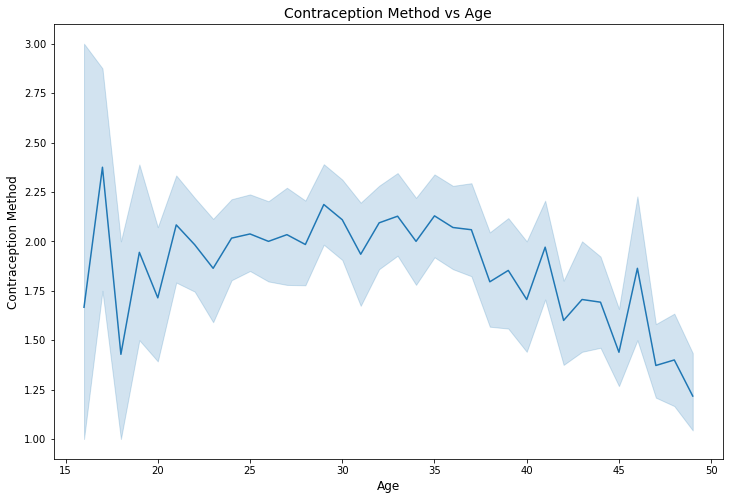

In [7]:
feature_plot(df, df.age, y, 'line', 'Age', xlog = 'n', ylog = 'n', color = u'#1f77b4')

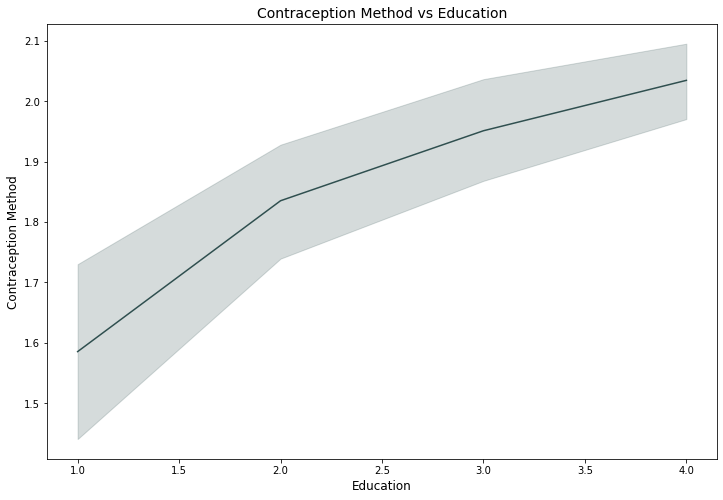

In [8]:
feature_plot(df, df.edu, y, 'line', 'Education', color = 'darkslategray')

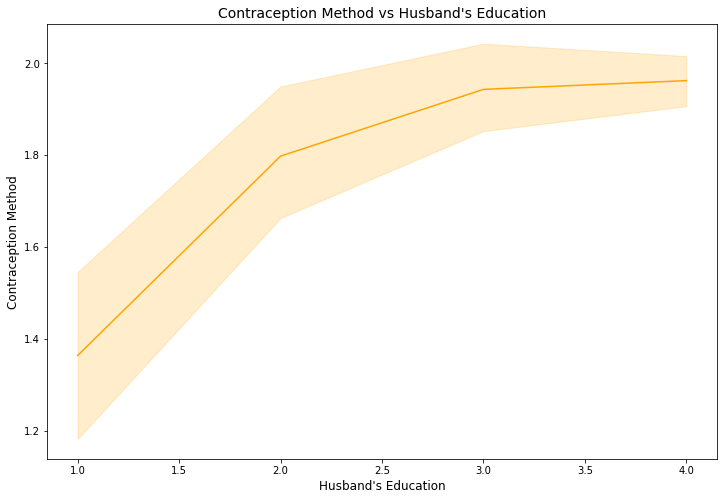

In [9]:
feature_plot(df, df.hus_edu, y, 'line', 'Husband\'s Education', color = 'orange')

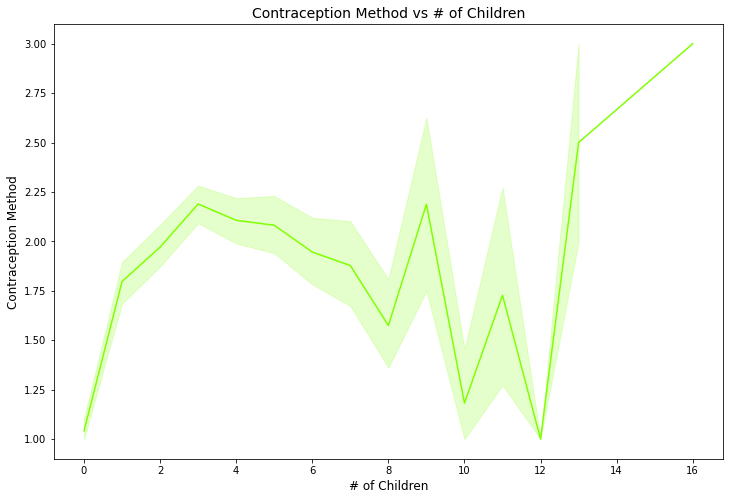

In [10]:
feature_plot(df, df.chil, y, 'line', '# of Children', color = 'chartreuse')

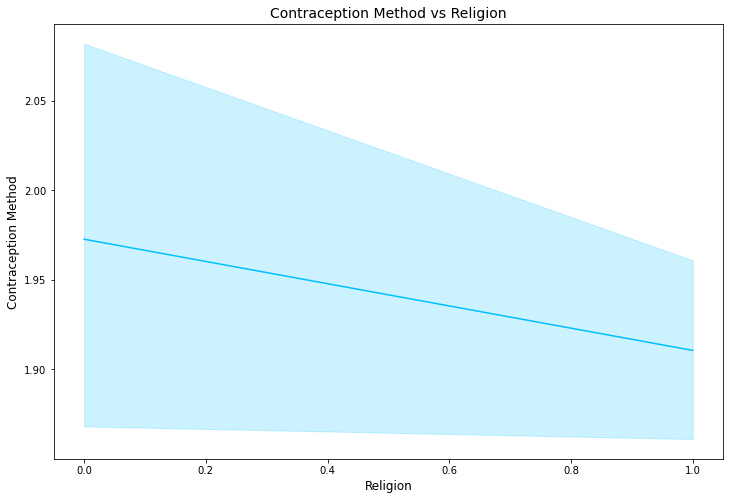

In [11]:
feature_plot(df, df.rel, y, 'line', 'Religion', color = 'deepskyblue')

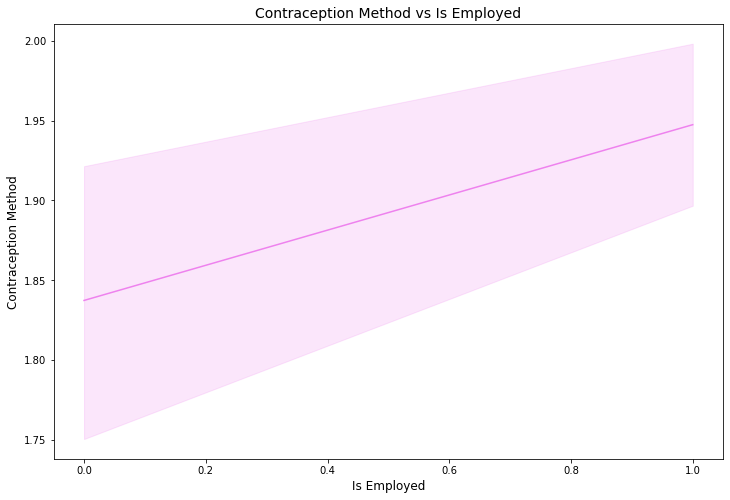

In [12]:
feature_plot(df, df.work, y, 'line', 'Is Employed', color = 'violet')

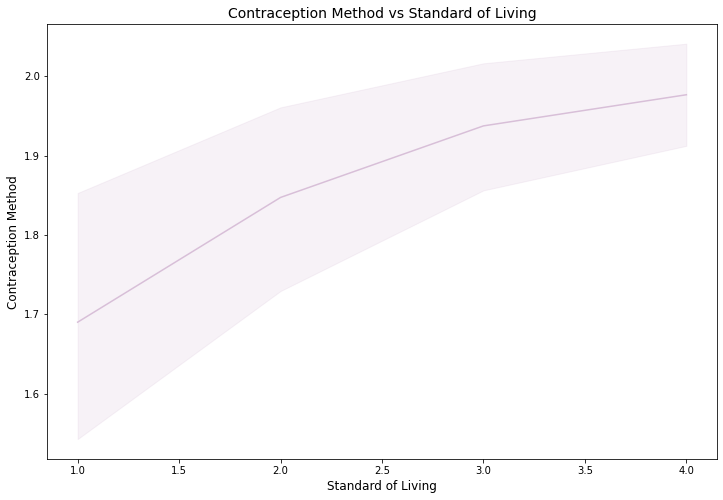

In [13]:
feature_plot(df, df.sol, y, 'line', 'Standard of Living', color = 'thistle')

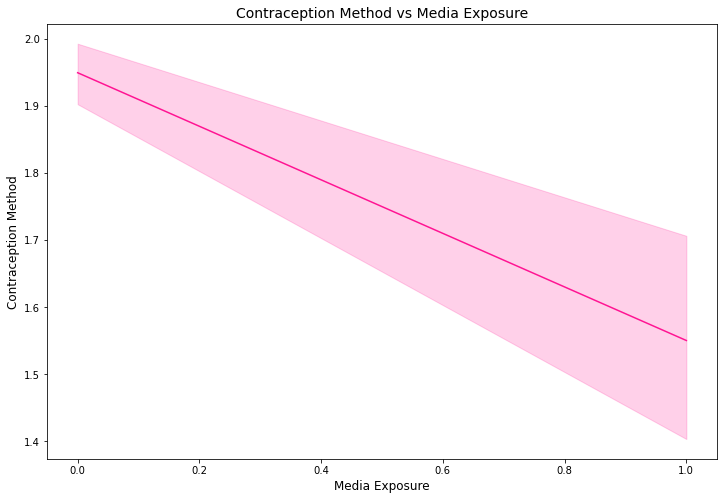

In [14]:
feature_plot(df, df.media, y, 'line', 'Media Exposure', color = 'deeppink')

# Data Preparation

## Dummying

In [15]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_with_dums = pd.get_dummies(X, columns=to_dummy, drop_first=True)
# X_with_dums = pd.get_dummies(df, columns=to_dummy)
X_with_dums.shape

(1473, 30)

## Split data into train and test sets

In [16]:
X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_with_dums, y, test_size=.25,
    random_state=1)
X_train_df.shape

(1104, 30)

## Scale features

In [17]:
rs = RobustScaler()

rs.fit(X_train_df)
X_train = rs.transform(X_train_df)
X_test = rs.transform(X_test_df)

# Modeling

## Logistic Regression - Base Model

Classifier:  LogisticRegression
Num features:  30
Model score:  0.5718157181571816
Accuracy score:  0.5718157181571816
Model F1 (micro):  0.5718157181571816
Model F1 (macro):  0.5405777690559126
Model F1 (weighted):  0.5660858901627333
Cross validation score:  [0.60810811 0.52702703 0.58108108 0.48648649 0.52054795]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.69      0.68       161
           2       0.59      0.33      0.43        87
           3       0.46      0.59      0.52       121

    accuracy                           0.57       369
   macro avg       0.57      0.54      0.54       369
weighted avg       0.58      0.57      0.57       369

One-vs-One ROC AUC scores:
0.753431 (macro),
0.756977 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.758908 (macro),
0.760028 (weighted by prevalence)


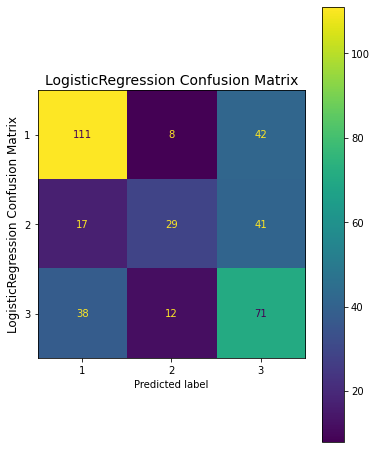

In [18]:
lr_base_clf = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr_base_clf.fit(X_train, y_train)
model_stats(X_train_df.columns, lr_base_clf, 'LogisticRegression', X_test, y_test)

## Logistic Regression w/ Children dummied

In [19]:
X

,age,edu,hus_edu,chil,rel,work,hus_ocu,sol,media
0,24,2,3,3,1,1,2,3,0
1,45,1,3,10,1,1,3,4,0
2,43,2,3,7,1,1,3,4,0
3,42,3,2,9,1,1,3,3,0
4,36,3,3,8,1,1,3,2,0
...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0
1469,33,4,4,3,1,1,1,4,0
1470,39,3,3,8,1,0,1,4,0
1471,33,3,3,4,1,0,2,2,0


In [20]:
y

0       1
1       1
2       1
3       1
4       1
       ..
1468    3
1469    3
1470    3
1471    3
1472    3
Name: cmc, Length: 1473, dtype: int64

{'lr__C': 78.47599703514607, 'lr__class_weight': 'balanced', 'lr__dual': True, 'lr__l1_ratio': 0.0001, 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Classifier:  LogisticRegression
Num features:  30
Model score:  0.5501355013550135
Accuracy score:  0.5501355013550135
Model F1 (micro):  0.5501355013550135
Model F1 (macro):  0.5352941467738181
Model F1 (weighted):  0.5494776055323054
Cross validation score:  [0.43243243 0.5        0.55405405 0.54054054 0.45205479]
Classification Report:
              precision    recall  f1-score   support

           1       0.67      0.59      0.63       149
           2       0.51      0.39      0.44        93
           3       0.47      0.62      0.54       127

    accuracy                           0.55       369
   macro avg       0.55      0.53      0.54       369
weighted avg       0.56      0.55      0.55       369

One-vs-One ROC AUC scores:
0.753592 (macro),
0.756264 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.757842 (macro),
0.

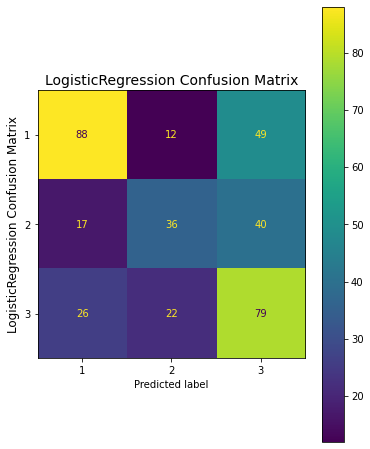

In [21]:
to_dummy = ['edu', 'hus_edu', 'chil', 'hus_ocu', 'sol']
X_dums, X_train, X_test, y_train, y_test = dummy_transform_scale(X, y, to_dummy, rs = 729)

# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=1, max_iter=200))])

params_grid_lr = {'lr__penalty' : ['l2','elasticnet'],
                  'lr__class_weight' : ['balanced'],
                  'lr__dual' : [True],
                  'lr__solver' : ['liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20) # only needed for elasticnet
                 }

lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

In [22]:
lr_clf_ = best_lr_clf.named_steps['lr']
coef_df = pd.DataFrame(lr_clf_.coef_, columns = X_with_dums.columns, index = [1,2,3])
coef_df

,age,rel,work,media,edu_2,edu_3,edu_4,hus_edu_2,hus_edu_3,hus_edu_4,chil_1,chil_2,chil_3,chil_4,chil_5,chil_6,chil_7,chil_8,chil_9,chil_10,chil_11,chil_12,chil_13,chil_16,hus_ocu_2,hus_ocu_3,hus_ocu_4,sol_2,sol_3,sol_4
1,1.192963,0.386439,-0.015671,0.836849,-0.264326,-0.811980,-1.563201,-0.517918,-0.502869,-0.343674,-3.049579,-4.120991,-4.937231,-5.182418,-5.307722,-5.400066,-5.429150,-4.622743,-5.970930,-3.400371,-5.385245,0.497486,-8.227727,-6.842369,0.311394,0.129267,-0.402819,-0.492769,-0.458654,-0.809895
2,-0.174025,-0.049188,0.082224,-0.670869,0.996179,1.535074,2.384683,-1.367942,-1.556864,-1.442816,3.067694,3.610249,3.914823,4.152293,4.301790,4.211853,5.198670,3.929521,3.799628,3.339665,3.304046,-0.335021,5.381559,-0.762801,-0.619008,-0.496934,-0.112311,0.184218,0.546370,0.886796
3,-1.425312,-0.030851,-0.099718,-0.417269,-0.186614,0.056073,0.165654,2.283291,1.856342,1.940207,2.345069,3.263409,3.841421,3.932285,4.291663,3.903763,3.135373,3.808292,5.023249,-1.172613,4.626520,-0.887507,5.320474,7.885285,0.153143,0.404961,0.742477,0.475456,0.418338,0.333350


In [23]:
fig, ax = plt.subplots(figsize = [10,8]
                       coef_df.loc[1].plot

SyntaxError: invalid syntax (<ipython-input-23-808933989321>, line 2)

## LogisticRegression GridSearchCV

In [ ]:
# set up pipeline
pipe_lr = Pipeline([('lr' , LogisticRegression(random_state=729, max_iter = 500))])

params_grid_lr = {# 'lr' : [LogisticRegression()],
                  'lr__penalty' : ['l1', 'l2', 'elasticnet'],
                  'lr__class_weight' : ['balanced', 'none'],
                  'lr__dual' : [True, False],
                  'lr__solver' : ['lbfgs', 'liblinear'],
                  'lr__C' : np.logspace(-4, 4, 20),
                  'lr__l1_ratio' : np.logspace(-4, 4, 20)
                 }

In [ ]:
lr_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# fit on data
lr_clf.fit(X_train, y_train)
print(lr_clf.best_params_)
best_lr_clf = lr_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_clf, 'LogisticRegression', X_test, y_test)

## RandomForestClassifier GridSearchCV

## Functions

In [ ]:
pipe_rfc = Pipeline([('rfc' , RandomForestClassifier())])

params_grid_rfc = {#'rfc' : [RandomForestClassifier()],
                   'rfc__n_estimators' : list(range(10,101,10)),
                   'rfc__max_features': ['auto', 'sqrt', 'log2'],
                   'rfc__max_depth' : list(range(1,10))
                  }

rfc_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

rfc_clf.fit(X_train, y_train)
print(rfc_clf.best_params_)
best_rfc_clf = rfc_clf.best_estimator_
model_stats(X_train_df.columns, best_rfc_clf, 'RandomForestClassifier', X_test, y_test)

## LogisticRegression GridSearchCV with Tomek Links resampling

In [ ]:
# def grid_search(model_type, X, y):
#     if model_type == log:
#         model = LogisticRegression()
#         params_grid = {
#             'multi_class': 'multinomial',
#             'solver': ['liblinear'],
#             'penalty': ['l1', 'l2'],
#             'C': np.logspace(-4, 4, 20),
#             'l1_ratio': stats.expon(scale=0.2),
#         }
#     elif model_type == dtc:
#         model = DecisionTreeClassifier()
#         params_grid = {
#             'criterion': ['gini', 'entropy'],
#             'max_depth': [None, 5, 3, 2],
#             'min_samples_split': [2, 10, 20]
#         }
#     elif model_type == knn:
#         model = KNeighborsClassifier()

#     gridsearch_model = GridSearchCV(estimator=model_type, param_grid=params_grid)

#     gridsearch_model.fit(X_train, y_train)
#     print(gridsearch_model.best_params_)
#     best_model = gridsearch_model.best_estimator_
#     best_model.score(X_test, y_test)

In [ ]:
tl = TomekLinks()
X_res, y_res = tl.fit_resample(X_train, y_train.ravel())
print('Resampled dataset shape %s' % Counter(y_res))

In [ ]:
# def log_reg(X_train, X_test, y_train, y_test):
#     # Split data into train and test sets
# #     X_train, X_test, y_train, y_test = train_test_split(
# #         X, y, test_size=.25,
# #         random_state=1)
    
#     # Scale the data for modeling
# #     log_scaler = StandardScaler()
# #     log_scaler.fit(X_train)
# #     X_train_sc = log_scaler.transform(X_train)
# #     X_test_sc = log_scaler.transform(X_test)
    
#     # Train a logistic regression model with the train data
#     log_model = LogisticRegression(multi_class='multinomial', max_iter=1000
# #                                    solver='lbfgs'
# #                                    solver='liblinear',
# #                                    C=.001,
# #                                    class_weight = 'balanced'
#                                   )
#     log_model.fit(X_train, y_train)
# #     y_pred = log_model.predict(X_test)
# #     y_prob = log_model.predict_proba(X_test)
#     model_stats(X_train_df.columns, log_model, X_test, y_test)
#     return log_model

In [ ]:
# Create grid search object
lr_tl_clf = GridSearchCV(pipe_lr, param_grid = params_grid_lr, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
lr_tl_clf.fit(X_res, y_res)
print(lr_tl_clf.best_params_)
best_lr_tl_clf = lr_tl_clf.best_estimator_
model_stats(X_train_df.columns, best_lr_tl_clf, 'LogisticRegression', X_test, y_test)

## RandomForestClassifier GridSearchCV with Tomek Links resampling

In [ ]:
# Create grid search object
rfc_tl_clf = GridSearchCV(pipe_rfc, param_grid = params_grid_rfc, cv = 5, verbose=0, n_jobs=-1)

# Fit on data
rfc_tl_clf.fit(X_res, y_res)
print(rfc_tl_clf.best_params_)
best_rfc_tl_clf = rfc_tl_clf.best_estimator_
model_stats(X_train_df.columns, best_rfc_tl_clf, 'RandomForestClassifier', X_test, y_test)

## XGBoost with GridSearchCV

In [ ]:
xgb = XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc')
xgb.fit(X_train, y_train)
model_stats(X_train_df.columns, xgb, 'XGBClassifier', X_test, y_test)

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],  # not a stat
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.5, 0.75],
                   'xgb__colsample_bynode': [0.5, 0.75],
                   'xgb__colsample_bytree': [0.5, 0.75],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [8, 10],
                   'xgb__min_child_weight': [7, 9],
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   #'xgb__objective': ['reg:squarederror'],
                   'xgb__subsample': [0.2, 0.5, 0.7]
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_train_df.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test)

In [ ]:
pipe_xgb = Pipeline([('xgb', XGBClassifier(random_state=729, learning_rate = 0.3, eval_metric = 'auc'))])
params_grid_xgb = {'xgb__nthread': [4],  # not a stat
                   'xgb__booster' : ['gbtree', 'gblinear', 'dart'],
                   'xgb__colsample_bylevel': [0.25, 0.4, 0.5],
                   'xgb__colsample_bynode': [0.25, 0.4, 0.75],
                   'xgb__colsample_bytree': [0.25, 0.4, 0.75],
                   #'xgb__learning_rate': np.linspace(0.1, 0.2, 6), # does not need
                   'xgb__max_depth': [6, 7, 8], # 7,8,10
                   'xgb__min_child_weight': [5, 6, 7], # 5,6,7,9
                   'xgb__missing': [-999],
                   'xgb__n_estimators': [250],
                   #'xgb__objective': ['reg:squarederror'],
                   'xgb__subsample': [0.1, 0.15, 0.2] # 0.15, 0.2, 0.5, 0.7
                  }
xgb_clf = GridSearchCV(pipe_xgb, params_grid_xgb, n_jobs=-1,
                  cv=StratifiedKFold(n_splits=3, shuffle=True), 
                  scoring='f1_weighted',
                  verbose=2, refit=True)
xgb_clf.fit(X_train, y_train)
print(xgb_clf.best_params_)
best_xgb_clf = xgb_clf.best_estimator_
model_stats(X_train_df.columns, best_xgb_clf, 'XGBClassifier', X_test, y_test)

In [ ]:
X_test

In [ ]:
xgb = XGBRFClassifier(random_state=729, learning_rate = 0.2, eval_metric = 'auc')
xgb.fit(X_train, y_train)
model_stats(X_train_df.columns, xgb, 'XGBRFClassifier', X_test, y_test)

# Using updated features, binary classification, and optimizing for Recall score

In [ ]:
# Cleaning: capping maximum children down to 12
df['chil'] = np.where(df.chil > 11,
                     12,
                     df.chil)

# FE: creating a feature that represents a binary for if wife's education is higher than husband's
df['wife_more_edu'] = np.where(df.edu >= df.hus_edu,
                              1,
                              0)

# FE: creating a feature that represents a binary for women who's education level is the lowest possible while also being not employed.
df['neet'] = np.where((df.edu == 1) 
                    & (df.work == 1),
                         1,
                         0)
# here we set a binary copy of our primary df, for use wherever we want to see ...
y_df = df.copy() # ... any contraceptive use vs. no contraceptive use
y_df['uses_cm'] = np.where(cm_df.cmc == 1, 
                            0, 
                            1)

X = df.copy()
y = X.pop('cmc')